<a href="https://colab.research.google.com/github/Anjasfedo/data-analysis/blob/main/Predictive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Predictive Analytic : Pima Indian Diabetes
- **Nama:** M. Anjasfedo Afridiansah
- **Email:** fedoafridiansah@gmail.com
- **ID Dicoding:** anjasfedo

In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, mean_squared_error,
                             r2_score, roc_auc_score, roc_curve, classification_report)
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

import missingno as msno
import warnings
warnings.simplefilter(action="ignore")
import joblib
import kagglehub

# Import Libraries & Packages

# Data Collection

In [62]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print("Path to dataset files:", path)

df = pd.read_csv(f"{path}/diabetes.csv")
df.info()

Path to dataset files: /kaggle/input/pima-indians-diabetes-database
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Data Understanding

In [63]:
df.Outcome.value_counts()

,count
Outcome,
0,500
1,268


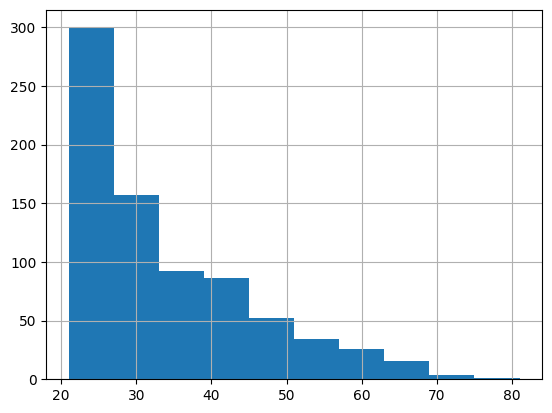

In [64]:
df["Age"].hist();

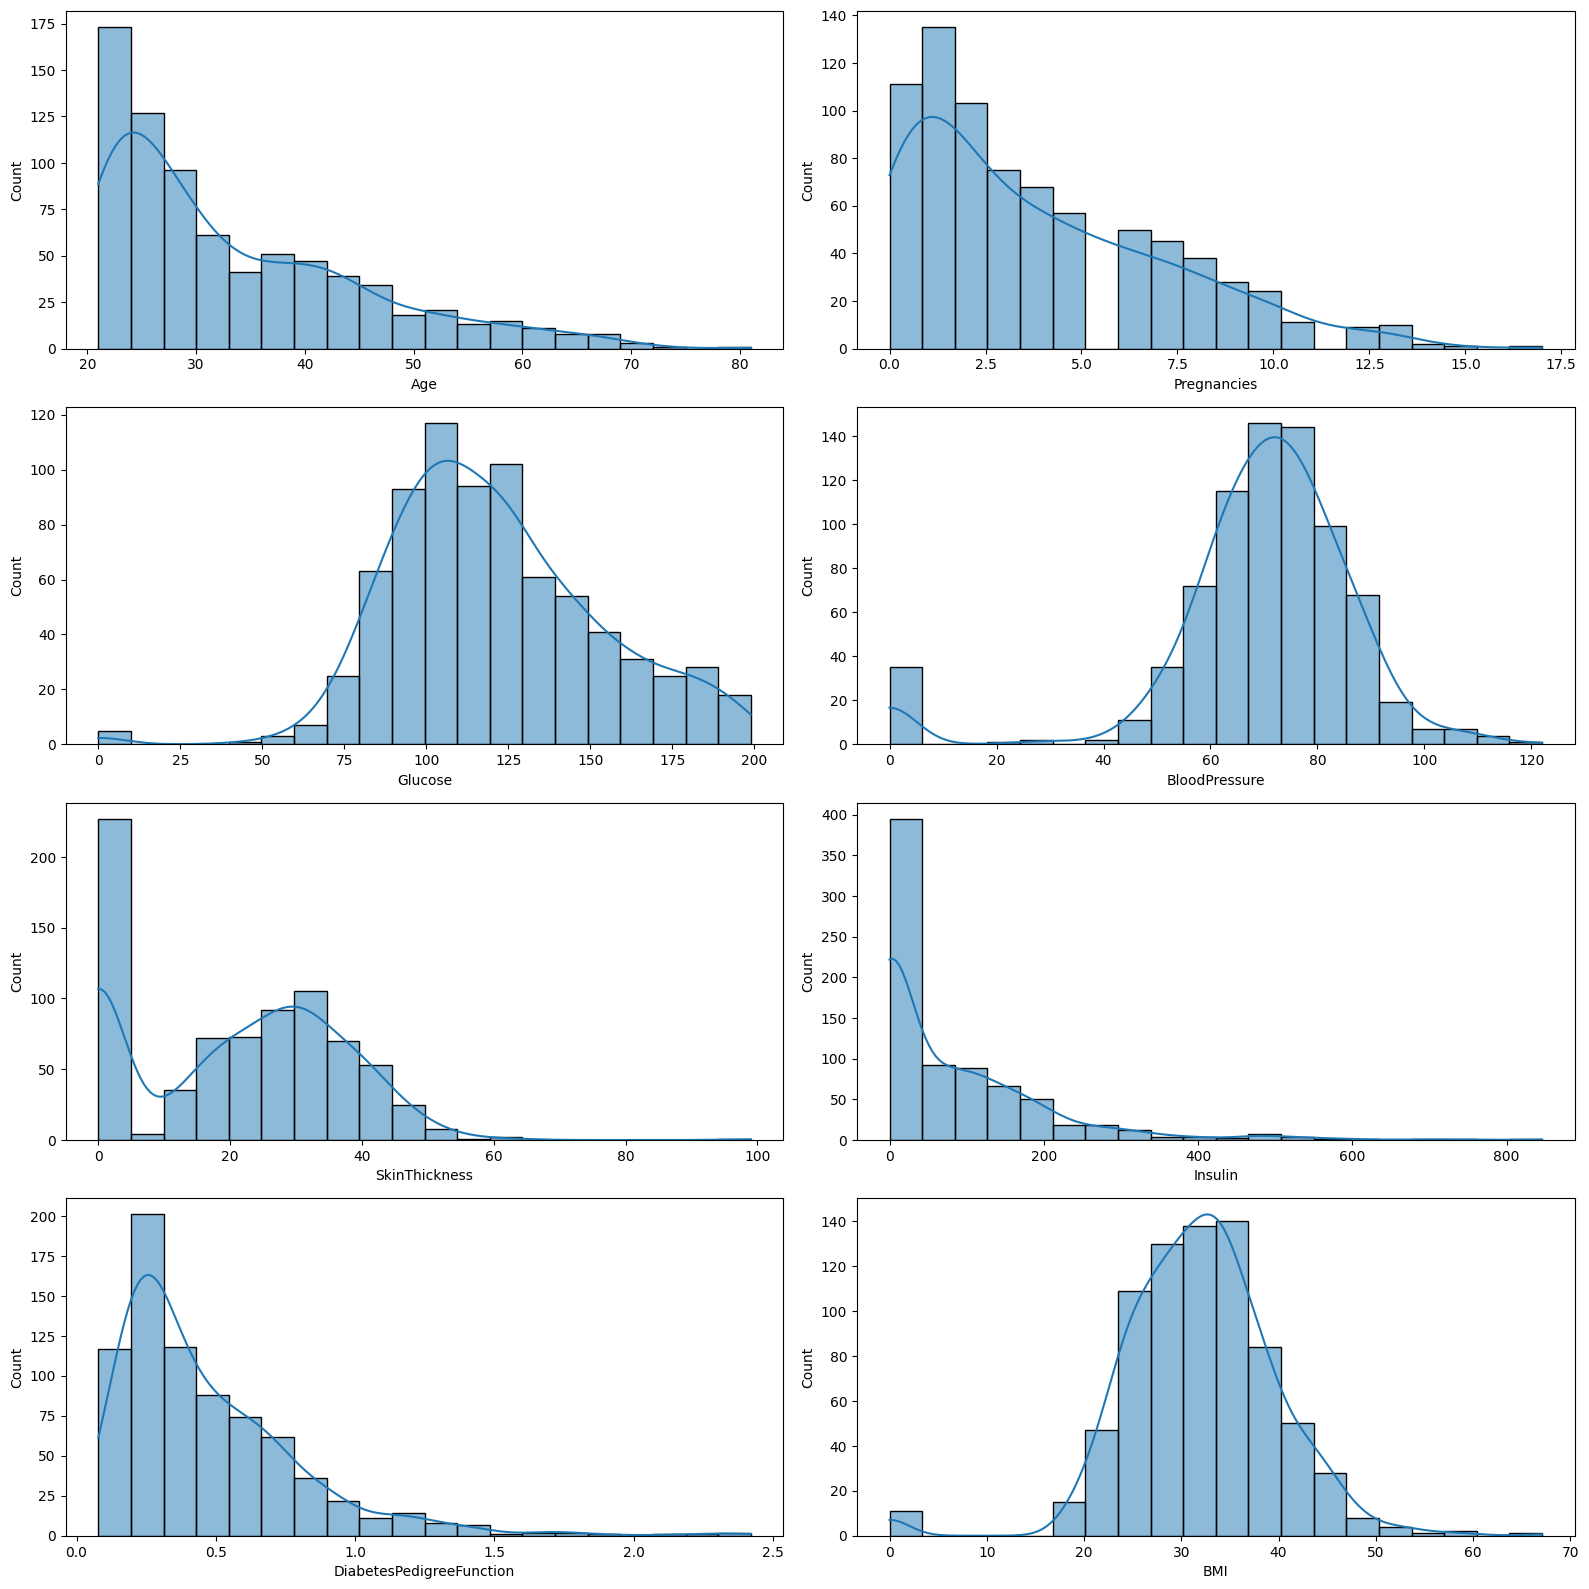

In [66]:
fig, ax = plt.subplots(4, 2, figsize=(16, 16))
features = [
    "Age", "Pregnancies", "Glucose", "BloodPressure",
    "SkinThickness", "Insulin", "DiabetesPedigreeFunction", "BMI"
]

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    sns.histplot(df[feature], bins=20, ax=ax[row, col], kde=True)
plt.tight_layout()
plt.show()

In [67]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


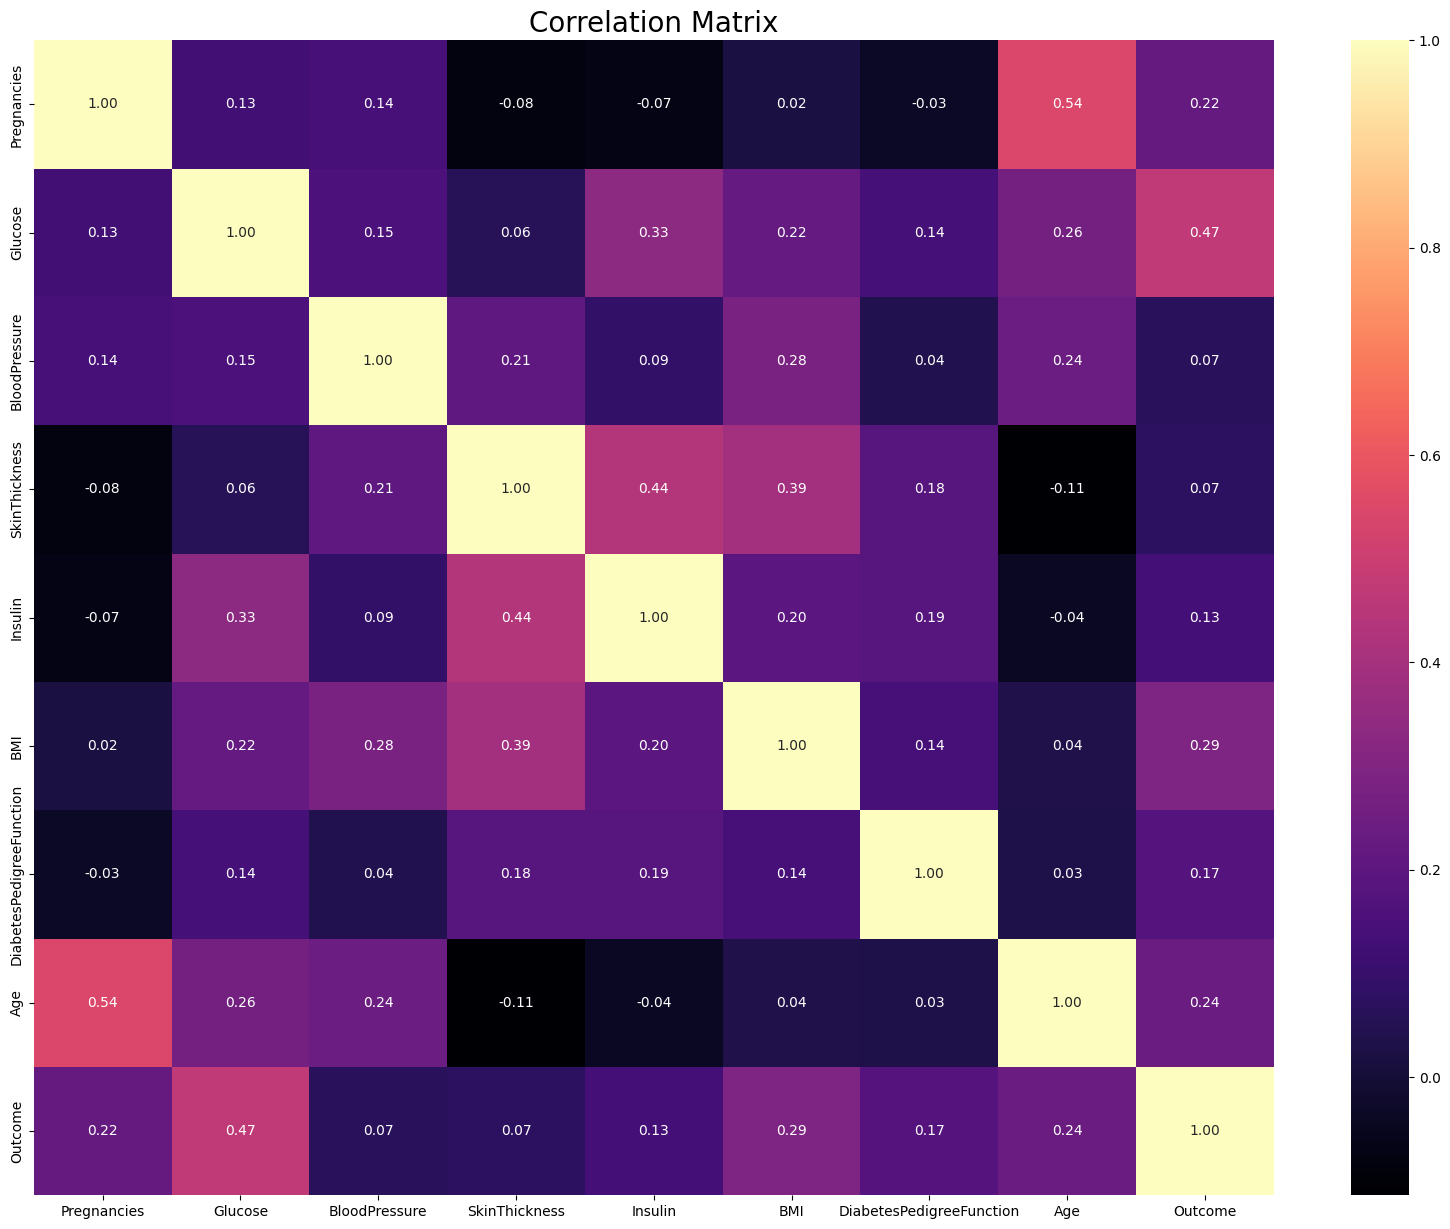

In [68]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# Data Preparation

### Mising Value

In [69]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

In [70]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [71]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


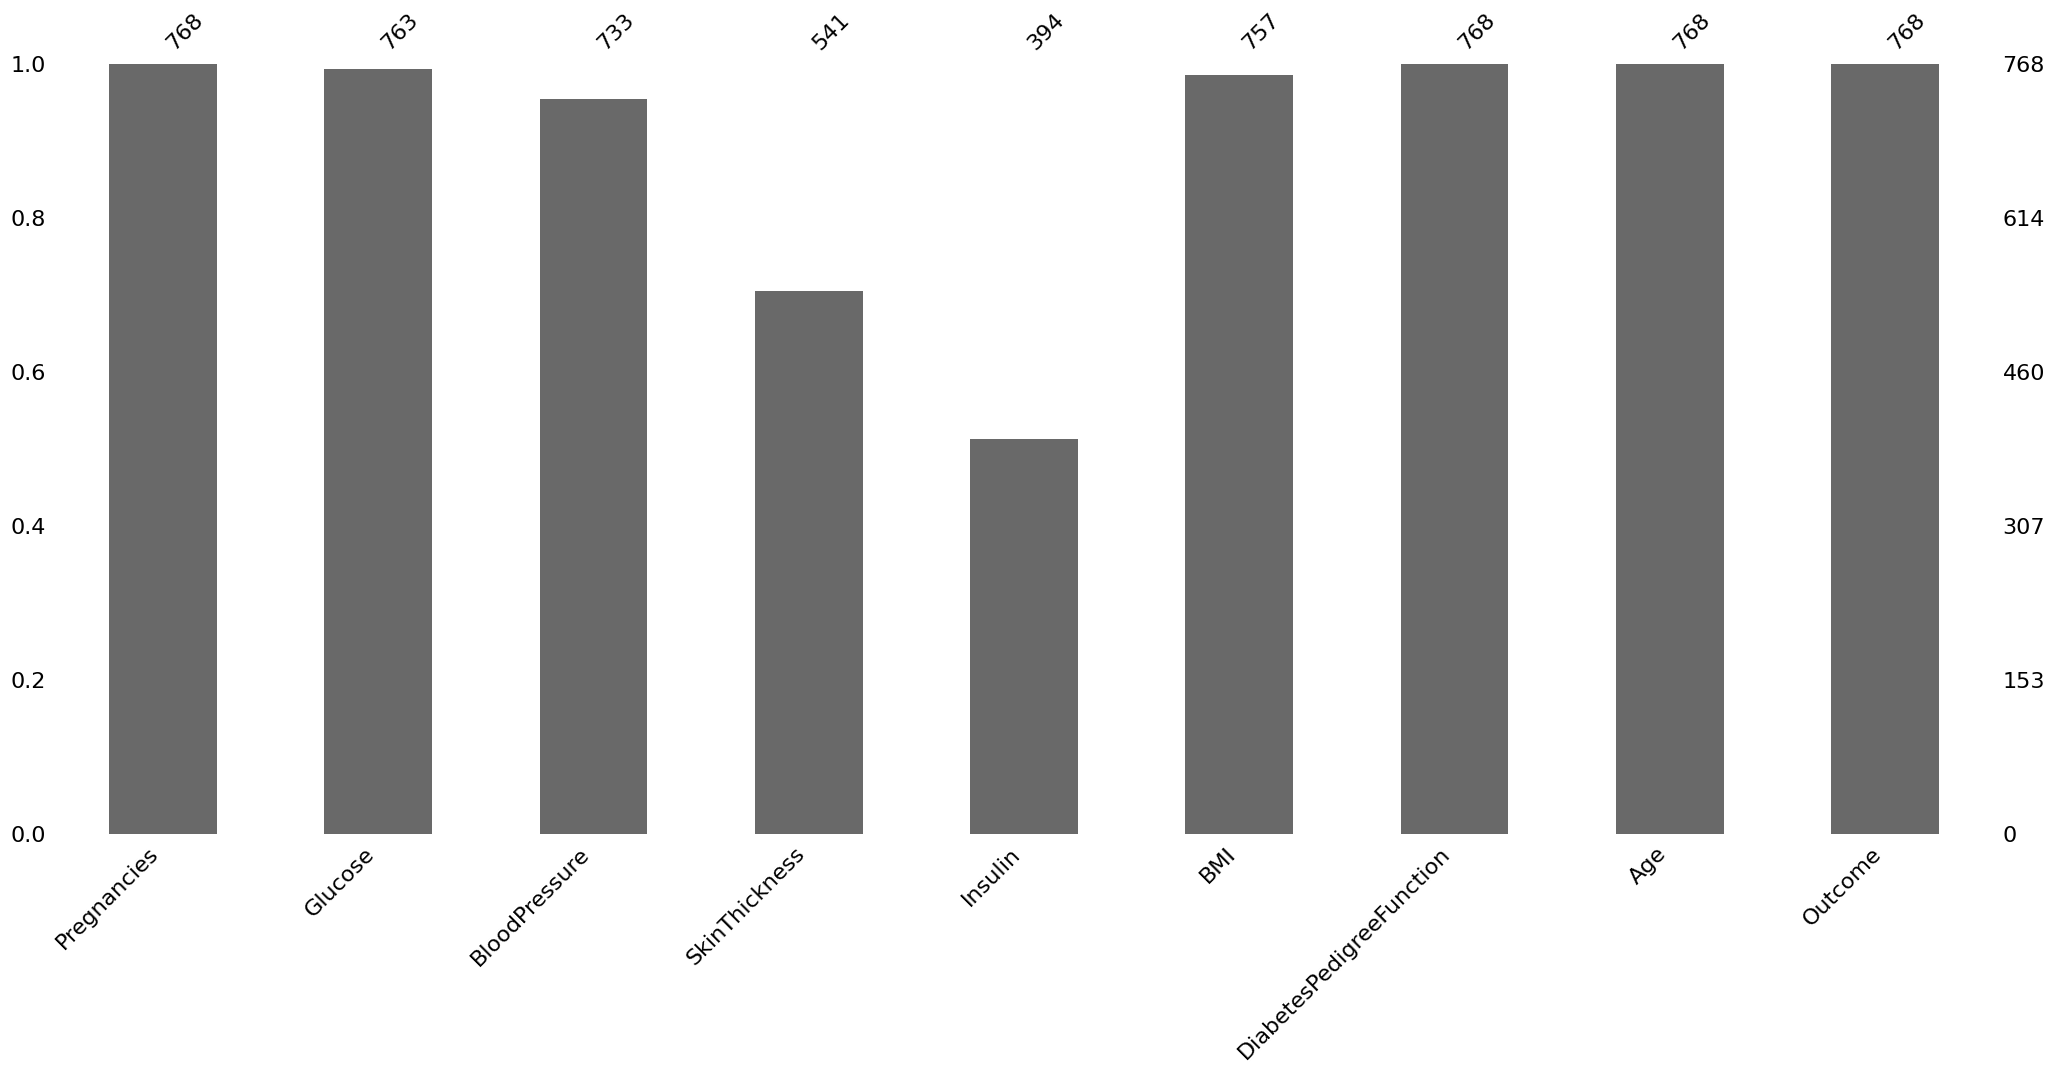

In [72]:
msno.bar(df);

In [73]:
def median_target(var):
    temp = df[df[var].notnull()]
    temp = temp.groupby('Outcome')[[var]].median().reset_index()
    return temp

In [74]:
columns = df.columns.drop("Outcome")
for col in columns:
    medians = median_target(col)
    df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = medians[col][0]
    df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = medians[col][1]

In [75]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [76]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


### Outlier

In [77]:
for feature in df.columns:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    has_outlier = (df[feature] > upper).any() or (df[feature] < lower).any()
    print(f"{feature} {'yes' if has_outlier else 'no'}")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


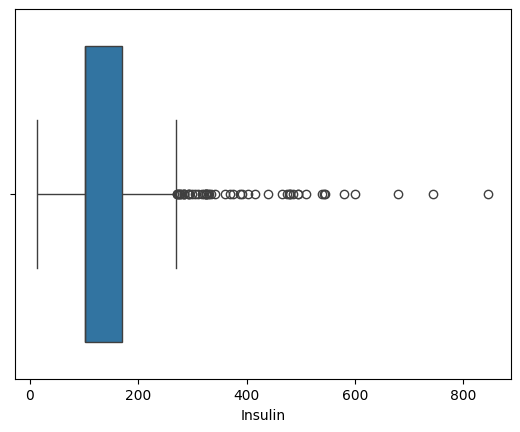

In [78]:
sns.boxplot(x = df["Insulin"]);

In [82]:
Q1 = df['Insulin'].quantile(0.25)
Q3 = df['Insulin'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
df.loc[df['Insulin'] > upper, 'Insulin'] = upper

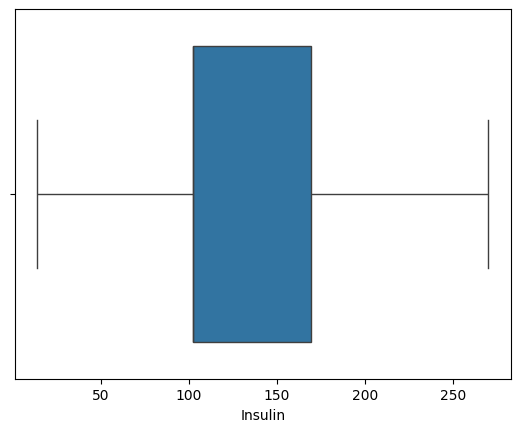

In [83]:
sns.boxplot(x = df["Insulin"]);

In [84]:
lof = LocalOutlierFactor(n_neighbors=10)
lof.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1

In [85]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[:30]

array([-3.05893469, -2.37289269, -2.15297995, -2.09708735, -2.0772561 ,
       -1.95255968, -1.86384019, -1.74003158, -1.72703492, -1.71674689,
       -1.70343883, -1.6688722 , -1.64296768, -1.64190437, -1.61620872,
       -1.61369917, -1.60057603, -1.5988774 , -1.59608032, -1.57027568,
       -1.55876022, -1.55674614, -1.51852389, -1.50843907, -1.50280943,
       -1.50160698, -1.48391514, -1.4752983 , -1.4713427 , -1.47006248])

In [86]:
threshold = np.sort(df_scores)[7]
threshold

np.float64(-1.740031580305444)

In [23]:
outlier = df_scores > threshold
df = df[outlier]

## Feature Engineering

In [87]:
bmi_categories = {
    "Underweight": lambda x: x < 18.5,
    "Normal": lambda x: 18.5 <= x <= 24.9,
    "Overweight": lambda x: 24.9 < x <= 29.9,
    "Obesity 1": lambda x: 29.9 < x <= 34.9,
    "Obesity 2": lambda x: 34.9 < x <= 39.9,
    "Obesity 3": lambda x: x > 39.9
}

def categorize_bmi(bmi):
    for category, condition in bmi_categories.items():
        if condition(bmi):
            return category
    return None

df["NewBMI"] = df["BMI"].apply(categorize_bmi).astype("category")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3


In [88]:
insulin_categories = {
    "Normal": lambda x: 16 <= x <= 166,
    "Abnormal": lambda x: x < 16 or x > 166
}

def categorize_insulin(insulin):
    for category, condition in insulin_categories.items():
        if condition(insulin):
            return category
    return None

df["NewInsulin"] = df["Insulin"].apply(categorize_insulin).astype("category")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulin
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Abnormal


In [89]:
glucose_categories = {
    "Low": lambda x: x <= 70,
    "Normal": lambda x: 70 < x <= 99,
    "Overweight": lambda x: 99 < x <= 126,
    "Secret": lambda x: x > 126
}

def categorize_glucose(glucose):
    for category, condition in glucose_categories.items():
        if condition(glucose):
            return category
    return None

df["NewGlucose"] = df["Glucose"].apply(categorize_glucose).astype("category")

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulin,NewGlucose
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal,Secret
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal,Secret
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Abnormal,Secret


## One Hot Encoding

In [90]:
df = pd.get_dummies(df, columns=["NewBMI", "NewInsulin", "NewGlucose"])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Normal,...,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulin_Abnormal,NewInsulin_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,False,...,False,False,False,False,True,False,False,False,False,True
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,False,...,False,False,True,False,False,True,False,True,False,False
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,True,...,False,False,False,False,True,False,False,False,False,True
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,False,...,False,False,True,False,False,True,False,True,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,False,...,False,True,False,False,True,False,False,False,False,True


In [91]:
categorical_df = df[[
    'NewBMI_Obesity 1', 'NewBMI_Obesity 2', 'NewBMI_Obesity 3',
    'NewBMI_Overweight', 'NewBMI_Underweight', 'NewBMI_Normal',
    'NewInsulin_Normal', "NewInsulin_Abnormal",
    'NewGlucose_Low', 'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'
]]

categorical_df.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewBMI_Normal,NewInsulin_Normal,NewInsulin_Abnormal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,True,False,False,False,False,False,False,True,False,False,False,True
1,False,False,False,True,False,False,True,False,False,True,False,False
2,False,False,False,False,False,True,False,True,False,False,False,True
3,False,False,False,True,False,False,True,False,False,True,False,False
4,False,False,True,False,False,False,False,True,False,False,False,True


In [92]:
y = df["Outcome"]

drop_cols = [
    'NewBMI_Obesity 1', 'NewBMI_Obesity 2', 'NewBMI_Obesity 3',
    'NewBMI_Overweight', 'NewBMI_Underweight', 'NewBMI_Normal',
    'NewInsulin_Normal',  "NewInsulin_Abnormal",
    'NewGlucose_Low', 'NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'
]

X = df.drop(["Outcome"] + drop_cols, axis=1)

cols = X.columns
index = X.index

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [93]:
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns=cols, index=index)

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.765432,0.000,1.000000,1.000000,0.170330,0.665359,1.235294
1,-0.4,-0.790123,-0.375,0.142857,0.000000,-0.598901,-0.056209,0.117647
2,1.0,1.629630,-0.500,0.571429,1.000000,-0.961538,0.783007,0.176471
3,-0.4,-0.691358,-0.375,-0.714286,-0.126866,-0.434066,-0.537255,-0.470588
4,-0.6,0.493827,-2.000,1.000000,0.977612,1.214286,5.007843,0.235294


## Split Data

In [94]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

## Grid Search CV

In [95]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters Found:
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Best Cross-Validation Score:
0.900719712115154


## Model Best Parameter

In [96]:
best_params = grid_search.best_params_

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Evaluation

## Classification Report

In [99]:
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        99
           1       0.81      0.76      0.79        55

    accuracy                           0.85       154
   macro avg       0.84      0.83      0.84       154
weighted avg       0.85      0.85      0.85       154



## Confusion Matrix

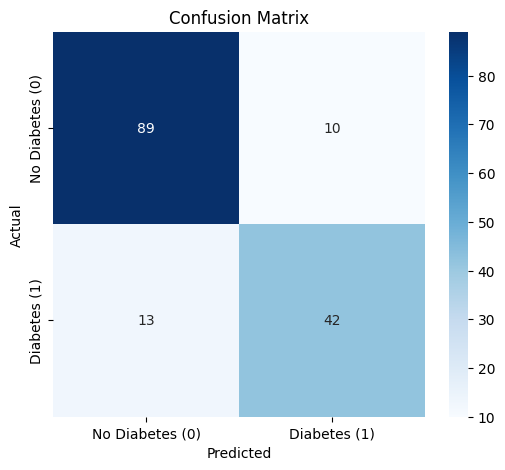

In [100]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Diabetes (0)', 'Diabetes (1)'],
    yticklabels=['No Diabetes (0)', 'Diabetes (1)']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()